In [1]:
%run "PDF text cleaning.ipynb"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2 non-null      int64 
 1   id          2 non-null      object
 2   title       2 non-null      object
 3   abstract    2 non-null      object
 4   published   2 non-null      object
 5   pdf_url     2 non-null      object
 6   full_text   2 non-null      object
 7   summary     2 non-null      object
dtypes: int64(1), object(7)
memory usage: 260.0+ bytes
Paper ID: 2102.07948v4

Abstract: A Kempe swap in a proper coloring interchanges the colors on some maximal
connected 2-colored subgraph. Two $k$-colorings are $k$-equivalent if we can
transform one into the other using Kempe swaps. The triangulated toroidal grid,
$T[m\times n]$, is formed from (a toroidal embedding of) the Cartesian product
of $C_m$ and $C_n$ by adding parallel diagonals inside all 4-faces. Mohar and
Salas showed that not a

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt', quiet=True)

def tfidf_summarize(text, top_n = 25):
    """ Generates a TF-IDF-based summary of a given text. """
    try:
        # Validate input
        if not isinstance(text, str):
            raise ValueError("Input text must be a string.")
        
        sentences = sent_tokenize(text)
        
        # Handle edge cases
        if not sentences:  # Empty input
            return "Error: No valid sentences found in text."
        if top_n <= 0:
            raise ValueError("Error: top_n must be greater than zero.")
        if len(sentences) <= top_n:
            return text  # If fewer sentences than top_n, return original text
        
        # Apply TF-IDF
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(sentences)

        # Compute sentence scores
        sentence_scores = np.array(tfidf_matrix.sum(axis = 1)).ravel()
        top_indices = sentence_scores.argsort()[-top_n:][::-1]
        top_sentences = [sentences[i] for i in sorted(top_indices)]
        
        return ' '.join(top_sentences)
    
    except ValueError as ve:
        return f"ValueError: {ve}"
    except Exception as e:
        return f"Unexpected error: {str(e)}"

# Apply TF-IDF summarization with error handling
df['tfidf_summary'] = df['clean'].apply(lambda x: tfidf_summarize(preprocess_pdf_text(x), top_n = 25))

# Display summaries 
for idx, row in df.head().iterrows():
    print(f"Document {idx} Summary:\n{row['tfidf_summary']}\n{'-'*100}")


Document 0 Summary:
2.1 An Introduction to Good Templates Given a coloring ϕ of G, our idea is to identify the vertices in one or more independent sets, each of which receives a common color under ϕ. If the resulting graph is 4-degenerate, then all of its 5-colorings are 5equivalent, as shown in Lemma 1; and these 5-colorings correspond to some of the 5-colorings of G (precisely those 5-colorings of G where the vertices in each identified independent set receive a common color). , k} is not used on the closed neighborhood 2For example, begin with the cartesian product of K3 and K2, drawn in the plane, and add a 4-vertex inside each 4-face. To simulate in G an α/β swap at a vertex v in GT , we simply perform an α/β swap at each vertex in G that was identified to form v. (If v ∈ V (G), then this is a single swap; but if v represents some non-singleton color of T , then this may be multiple swaps.) So most of the work in proving our Main Theorem (as well as Theorem 1) goes to showing that

In [3]:

from rouge_score import rouge_scorer

# Define reference (original text) and predicted (summary)
reference = df['clean'].iloc[0]
summary = df['tfidf_summary'].iloc[0]

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(reference, summary)

# Extract and display scores separately
for rouge_type, score_values in scores.items():
    print(f"{rouge_type.upper()}:")
    print(f"  Reference to Predicted (Recall): {score_values.recall:.4f}")
    print(f"  Predicted to Reference (Precision): {score_values.precision:.4f}")
    print(f"  F1-score (Balance): {score_values.fmeasure:.4f}")
    print("-" * 40)



ROUGE1:
  Reference to Predicted (Recall): 0.0832
  Predicted to Reference (Precision): 1.0000
  F1-score (Balance): 0.1537
----------------------------------------
ROUGE2:
  Reference to Predicted (Recall): 0.0816
  Predicted to Reference (Precision): 0.9816
  F1-score (Balance): 0.1507
----------------------------------------
ROUGEL:
  Reference to Predicted (Recall): 0.0832
  Predicted to Reference (Precision): 1.0000
  F1-score (Balance): 0.1537
----------------------------------------


The summary has high precision meaning that it is highly relevant to the original paper. It also features low recall which reflects that some key information may be missing in the summary. The f1-score suggests that while the summary maybe accurate with high precision it is not thorough enough and need better retention of the original contents.

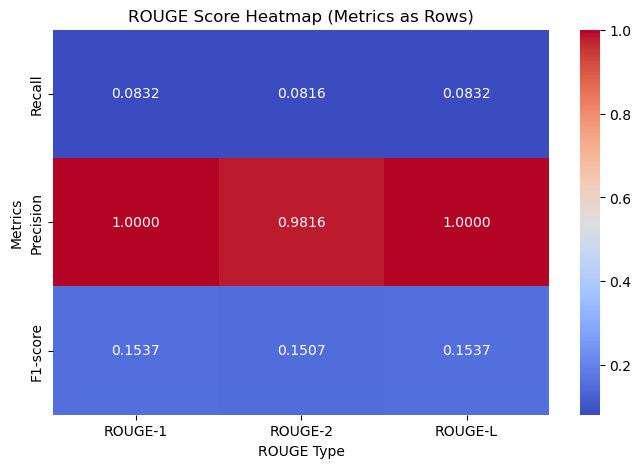

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#plot to visualize the rouge scores
metrics = ['Recall', 'Precision', 'F1-score']
rouge_types = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
data = np.array([
    [scores['rouge1'].recall, scores['rouge2'].recall, scores['rougeL'].recall],
    [scores['rouge1'].precision, scores['rouge2'].precision, scores['rougeL'].precision],
    [scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure]
])

df = pd.DataFrame(data, index=metrics, columns=rouge_types)

# Plotting the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("ROUGE Score Heatmap (Metrics as Rows)")
plt.xlabel("ROUGE Type")
plt.ylabel("Metrics")
plt.show()
